In [ ]:
# Step 1: Import Libraries
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
import zipfile

print("✅ TensorFlow Version:", tf.__version__)


✅ TensorFlow Version: 2.18.0


In [ ]:
# Step 2: Mount Drive and Set Constants
from google.colab import drive
drive.mount('/content/drive')

IMAGE_SIZE = 128
CHANNELS = 3
BATCH_SIZE = 16
EPOCHS = 30  # Reduced to avoid overfitting


Mounted at /content/drive


In [ ]:
# Step 3: Extract Dataset from ZIP
ZIP_FILE = "/content/drive/MyDrive/TomatoDataSets/TomatoVillage.zip"
EXTRACT_PATH = Path("dataset")

if os.path.exists(ZIP_FILE):
    with zipfile.ZipFile(ZIP_FILE, 'r') as zip_ref:
        zip_ref.extractall(EXTRACT_PATH)
    print("✅ Extracted:", os.listdir(EXTRACT_PATH))
else:
    print("❌ ZIP file not found at the given path.")


✅ Extracted: ['PlantVillage']


In [ ]:
# Step 4: Load Dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    EXTRACT_PATH / "PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

class_names = dataset.class_names
print("✅ Class names:", class_names)

# Preview batch
for images, labels in dataset.take(1):
    print("Image batch shape:", images.shape)
    print("Label batch:", labels.numpy())


Found 16011 files belonging to 10 classes.
✅ Class names: ['Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']
Image batch shape: (16, 128, 128, 3)
Label batch: [7 2 4 6 5 7 6 5 6 7 4 7 1 1 2 1]


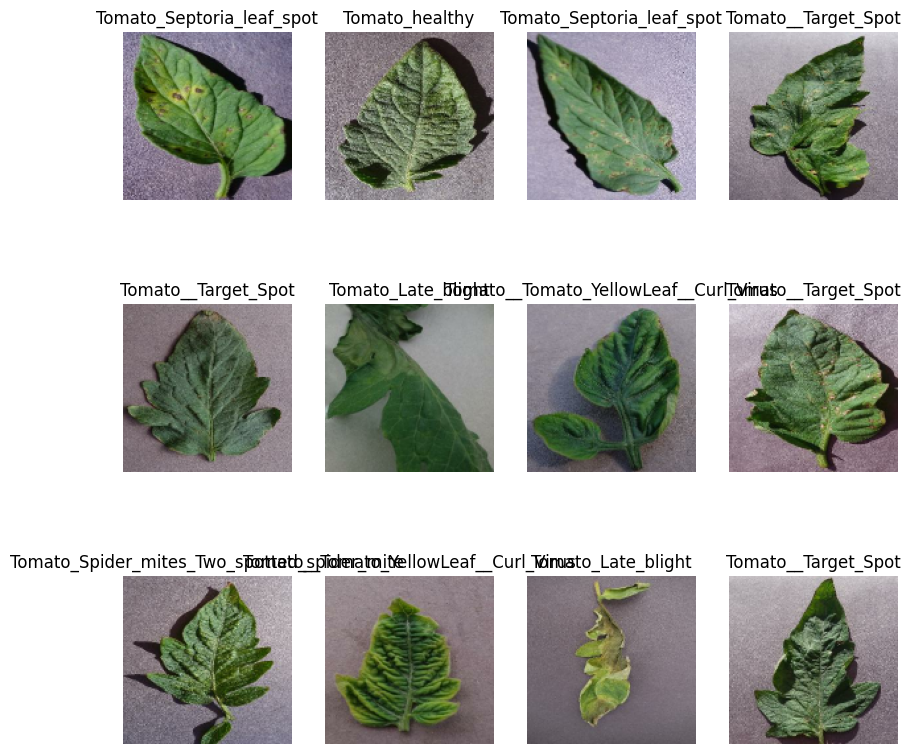

In [ ]:
# Step 5: Visualize 12 Samples
plt.figure(figsize=(10, 10))
for images, labels in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()


In [ ]:
# Step 6: Split Dataset
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1):
    ds_size = tf.data.experimental.cardinality(ds).numpy()
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

train_ds = train_ds.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(tf.data.AUTOTUNE)

print("✅ Dataset split complete.")


✅ Dataset split complete.


In [ ]:
# Step 7: Preprocess
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1./255)
])

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

train_ds = train_ds.map(lambda x, y: (data_augmentation(resize_and_rescale(x), training=True), y))
val_ds = val_ds.map(lambda x, y: (resize_and_rescale(x), y))
test_ds = test_ds.map(lambda x, y: (resize_and_rescale(x), y))

print("✅ Preprocessing applied.")


✅ Preprocessing applied.


In [ ]:
# Step 8: Build & Train Model (Optimized)
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = len(class_names)

model = models.Sequential([
    layers.Input(shape=input_shape),

    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.4),  # Increase dropout to reduce overfitting
    layers.Dense(n_classes, activation='softmax'),
])

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/30
800/800 ━━━━━━━━━━━━━━━━━━━━ 538s 657ms/step - accuracy: 0.3000 - loss: 1.9217 - val_accuracy: 0.5894 - val_loss: 1.1271
Epoch 2/30
800/800 ━━━━━━━━━━━━━━━━━━━━ 508s 635ms/step - accuracy: 0.5575 - loss: 1.2482 - val_accuracy: 0.7200 - val_loss: 0.7950
Epoch 3/30
800/800 ━━━━━━━━━━━━━━━━━━━━ 498s 622ms/step - accuracy: 0.6508 - loss: 1.0120 - val_accuracy: 0.7500 - val_loss: 0.7177
Epoch 4/30
800/800 ━━━━━━━━━━━━━━━━━━━━ 501s 622ms/step - accuracy: 0.6999 - loss: 0.8761 - val_accuracy: 0.7706 - val_loss: 0.7101
Epoch 5/30
800/800 ━━━━━━━━━━━━━━━━━━━━ 500s 625ms/step - accuracy: 0.7214 - loss: 0.7911 - val_accuracy: 0.8012 - val_loss: 0.5833
Epoch 6/30
800/800 ━━━━━━━━━━━━━━━━━━━━ 501s 626ms/step - accuracy: 0.7538 - loss: 0.7011 - val_accuracy: 0.8413 - val_loss: 0.4418
Epoch 7/30
800/800 ━━━━━━━━━━━━━━━━━━━━ 498s 622ms/step - accuracy: 0.7774 - loss: 0.6199 - val_accuracy: 0.8775 - val_loss: 0.3631
Epoch 8/30
800/800 ━━━━━━━━━━━━━━━━━━━━ 499s 623ms/step - accuracy: 0.8055 -

101/101 ━━━━━━━━━━━━━━━━━━━━ 30s 189ms/step - accuracy: 0.9545 - loss: 0.1286
✅ Test Accuracy: 95.53%


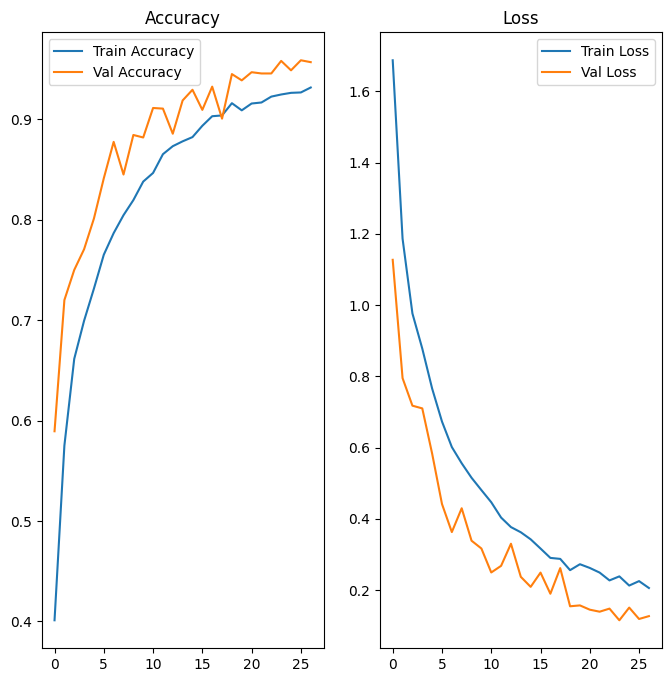

In [ ]:
# Step 9: Evaluate & Visualize

test_loss, test_acc = model.evaluate(test_ds)
print(f"✅ Test Accuracy: {test_acc*100:.2f}%")

# Accuracy and loss plots
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label="Train Accuracy")
plt.plot(val_acc, label="Val Accuracy")
plt.legend()
plt.title("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(loss, label="Train Loss")
plt.plot(val_loss, label="Val Loss")
plt.legend()
plt.title("Loss")
plt.show()


In [ ]:
# Step 10: Save model (.keras for backend)

model_path = "/content/tomato_new_model.keras"
model.save(model_path)
print(f"✅ Model saved to: {model_path}")

# Optional: download locally
from google.colab import files
files.download(model_path)


✅ Model saved to: /content/tomato_new_model.keras


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>